<a href="https://colab.research.google.com/github/Victor0vich/Denis/blob/main/RIA_parsing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект по анализу данных с сайта РИА Новости

### Часть 1.1
### Реализация парсера

In [ ]:
%%capture
!pip install selenium

In [ ]:
import re
import time
import datetime
import pandas as pd
from tqdm import tqdm
from bs4 import BeautifulSoup
from selenium import webdriver
from dataclasses import dataclass

In [ ]:
SLEEP = 2
DEPTH = 500
BASE_URL = 'https://ria.ru/'
TOPICS = ['politics', 'world', 'economy', 'society', 'incidents']

In [ ]:
@dataclass
class Article:
    id: str = None
    url: str = None
    title: str = None
    subtitle: str = None
    content: str = None
    datetime: str = None
    views: int = None

In [ ]:
# set webdriver params
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('headless')
chrome_options.add_argument('no-sandbox')
chrome_options.add_argument('disable-dev-shm-usage')
driver = webdriver.Chrome(options=chrome_options)

# driver = webdriver.Chrome('./chromedriver')

In [ ]:
def get_pages():

    """Load and scroll pages"""

    items, topics_order = [], []

    for topic in tqdm(TOPICS):
        try:
            old_size = len(items)
            URL = BASE_URL + topic
            driver.get(URL)
            time.sleep(SLEEP)

            # push to list 20 next articles
            driver.execute_script("document.getElementsByClassName('list-more')[0].click()")
            time.sleep(1)

            # scroll page to automatically load more articles
            for i in tqdm(range(DEPTH), leave=False):
                try:
                    driver.execute_script(f'window.scrollTo(0, document.body.scrollHeight - 1200)')
                    time.sleep(1)
                except:
                    pass

            # find all pages
            html = driver.page_source
            soup = BeautifulSoup(html, "html.parser")
            scope = soup.find('div', {'class' : 'list', 'itemtype': 'http://schema.org/ItemList'})
            items += scope.find_all('div', {'class': 'list-item'})

            # number of pages can not be multiple of deepth*20
            # that's why we count topics_order dynamically
            new_size = len(items)
            if new_size > old_size:
                topics_order.extend([topic] * (new_size - old_size))
        except:
            pass

    return items, topics_order

In [ ]:
def parse_page(page):
    """Extract from page desired fields"""

    # Create article data class object
    article = Article()

    # article url
    article.url = page.find('a', {'class': 'list-item__image'})['href']

    # article id
    s = re.findall(r'\d+.html', article.url)[0]
    article.id = s[ : s.find('.')]

    # load page
    driver.get(article.url)
    time.sleep(SLEEP)
    html = driver.page_source

    # article source
    source = article.url[8: article.url.find('.')]

    # article object
    soup = BeautifulSoup(html, "html.parser")
    obj = soup.find('div', {'class': lambda x: x and (x.find(f'article m-article m-{source}') > -1),
                                'data-article-id': article.id})

    if not obj:
        obj = soup.find('div', {'class': lambda x: x and (x.find(f'article m-video m-{source}') > -1),
                                'data-article-id': article.id})

    # process article title
    title = obj.find('div', {'class': 'article__title'})
    title_2 = obj.find('h1', {'class': 'article__title'})

    if title:
        article.title = title.text
    else:
        article.title = title_2.text if title_2 else ''

    # article subtitle
    subtitle = obj.find('h1', {'class': 'article__second-title'})
    article.subtitle = subtitle.text if subtitle else ''

    # article content
    article.content = obj.find('div', {'class': 'article__body js-mediator-article mia-analytics'}).text

    # article datetime
    article.datetime = obj.find('div', {'class': 'article__info-date'}).find('a').text

    # article number of views
    article.views = int(obj.find('span', {'class': 'statistic__item m-views'}).text)

    return article

In [ ]:
# get pages and topics
pages, topics_order = get_pages()
# with open('pages.txt', 'w') as f:
#     for page in pages:
#         f.write("%s\n" % page)

In [ ]:
# parse each page and get desired attributes
# few pages are differ significantly from others
# using try/except we can ignore them
data, topics_order_fixed = [], []
for num, page in enumerate(tqdm(pages)):
    try:
        res = parse_page(page)
        data.append(res)
        topics_order_fixed.append(topics_order[num])
    except:
        pass

driver.close()

In [ ]:
df = pd.DataFrame(data=data)
df['topic'] = topics_order_fixed
df.head()

In [ ]:
df.to_pickle('df_final.p', compression='gzip')

---

### Часть 1.2
### Первичный анализ данных

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

sns.set(style="darkgrid")
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mariagold/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Основные описательные статистики + визуальный анализ данных. Важно отметить интересные моменты в ваших данных до проведения исследования:
- определить особенности выборки по результатам первичного анализ, удаление выбросов и т.д.
- отметить моменты, которые позволят до проведения расчетов и построения моделей, выдвинуть несколько гипотез/предположений о результатах следующих этапов и т.д.
---

- Распределение категорий
- Распределение времени новостей
- Распределение просмотров
- Распределение по длине заголовка
- Распределение по длине текста
- Распределение просмотров в по топикам
- Ключевые слова по каждой из тематик

In [ ]:
df = pd.read_pickle('df_final.p', compression='gzip')
df.drop(columns='id', inplace=True)
df = df.reset_index(drop=True)

In [ ]:
df.head()

url  \
0  https://ria.ru/20211224/ryabkov-1765290924.html   
1   https://ria.ru/20211224/sovfed-1765285802.html   
2    https://ria.ru/20211224/aliev-1765284689.html   
3    https://ria.ru/20211224/aliev-1765277787.html   
4    https://ria.ru/20211224/volya-1765275809.html   

                                               title  \
0  Западу стоит учитывать решимость Москвы и Пеки...   
1  Совфед ратифицировал конвенцию о помощи по сем...   
2              Путин поговорил по телефону с Алиевым   
3             Путин поздравил Алиева с днем рождения   
4  В МИД заявили об отсутствии политической воли ...   

                                            subtitle  \
0  Дипломат Рябков: Западу стоит учесть решимость...   
1  Совфед ратифицировал конвенцию о помощи по гра...   
2  Президент Путин поговорил по телефону с главой...   
3  Президент Путин направил главе Азербайджана по...   
4  Дипломат Полищук: Киев может быстро выполнить ...   

                                             content          datetime  views  \
0  МОСКВА, 24 дек - РИА Новости. Странам Запада н...  11:19 24.12.2021    881   
1  МОСКВА, 24 дек - РИА Новости. Совет Федерации ...  10:59 24.12.2021    141   
2  МОСКВА, 24 дек - РИА Новости. Президент России...  10:56 24.12.2021    801   
3  МОСКВА, 24 дек - РИА Новости. Президент России...  10:05 24.12.2021   1446   
4  МОСКВА, 24 дек - РИА Новости. Украина при нали...  09:50 24.12.2021    460   

      topic  
0  politics  
1  politics  
2  politics  
3  politics  
4  politics

In [ ]:
# Размер датасета
df.shape

(22639, 7)

In [ ]:
# Размер каждой категории
df.topic.value_counts()

incidents    4557
world        4551
economy      4513
politics     4512
society      4506
Name: topic, dtype: int64

Видим, что в целом наши категории вполне сбалансированы. Это не удивительно, поскольку мы настроили парсер именно так, чтобы выгрузить по каждой тематике приблизительно равное количество статей.

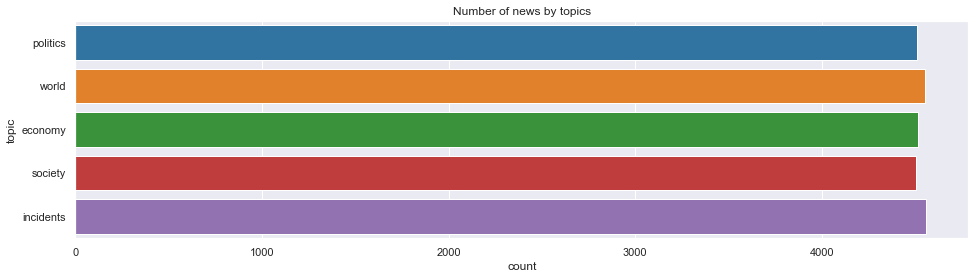

In [ ]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(16,4))
sns.countplot(y=df["topic"], palette='tab10', ax=ax)
plt.title('Number of news by topics');

Сама по себе дата как строка не является признаком, однако ее компоненты могут играть важную роль в работе модели. Поэтому мы преобразуем строковую дату в формат datetime и добавим к нашим признакам год, месяц и день недели.

In [ ]:
df['datetime'] = pd.to_datetime(df.datetime)
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.strftime("%B")
df['weekday'] = df['datetime'].dt.strftime('%A')

Какие выводы можно сделать по графикам ниже:
- Все новости относятся к 2021 году
- Больше всего новостей приходится на конец года (Ноябрь, Декабрь - лидер)
- Меньше всего новостей в выходные и больше всего в начале недели

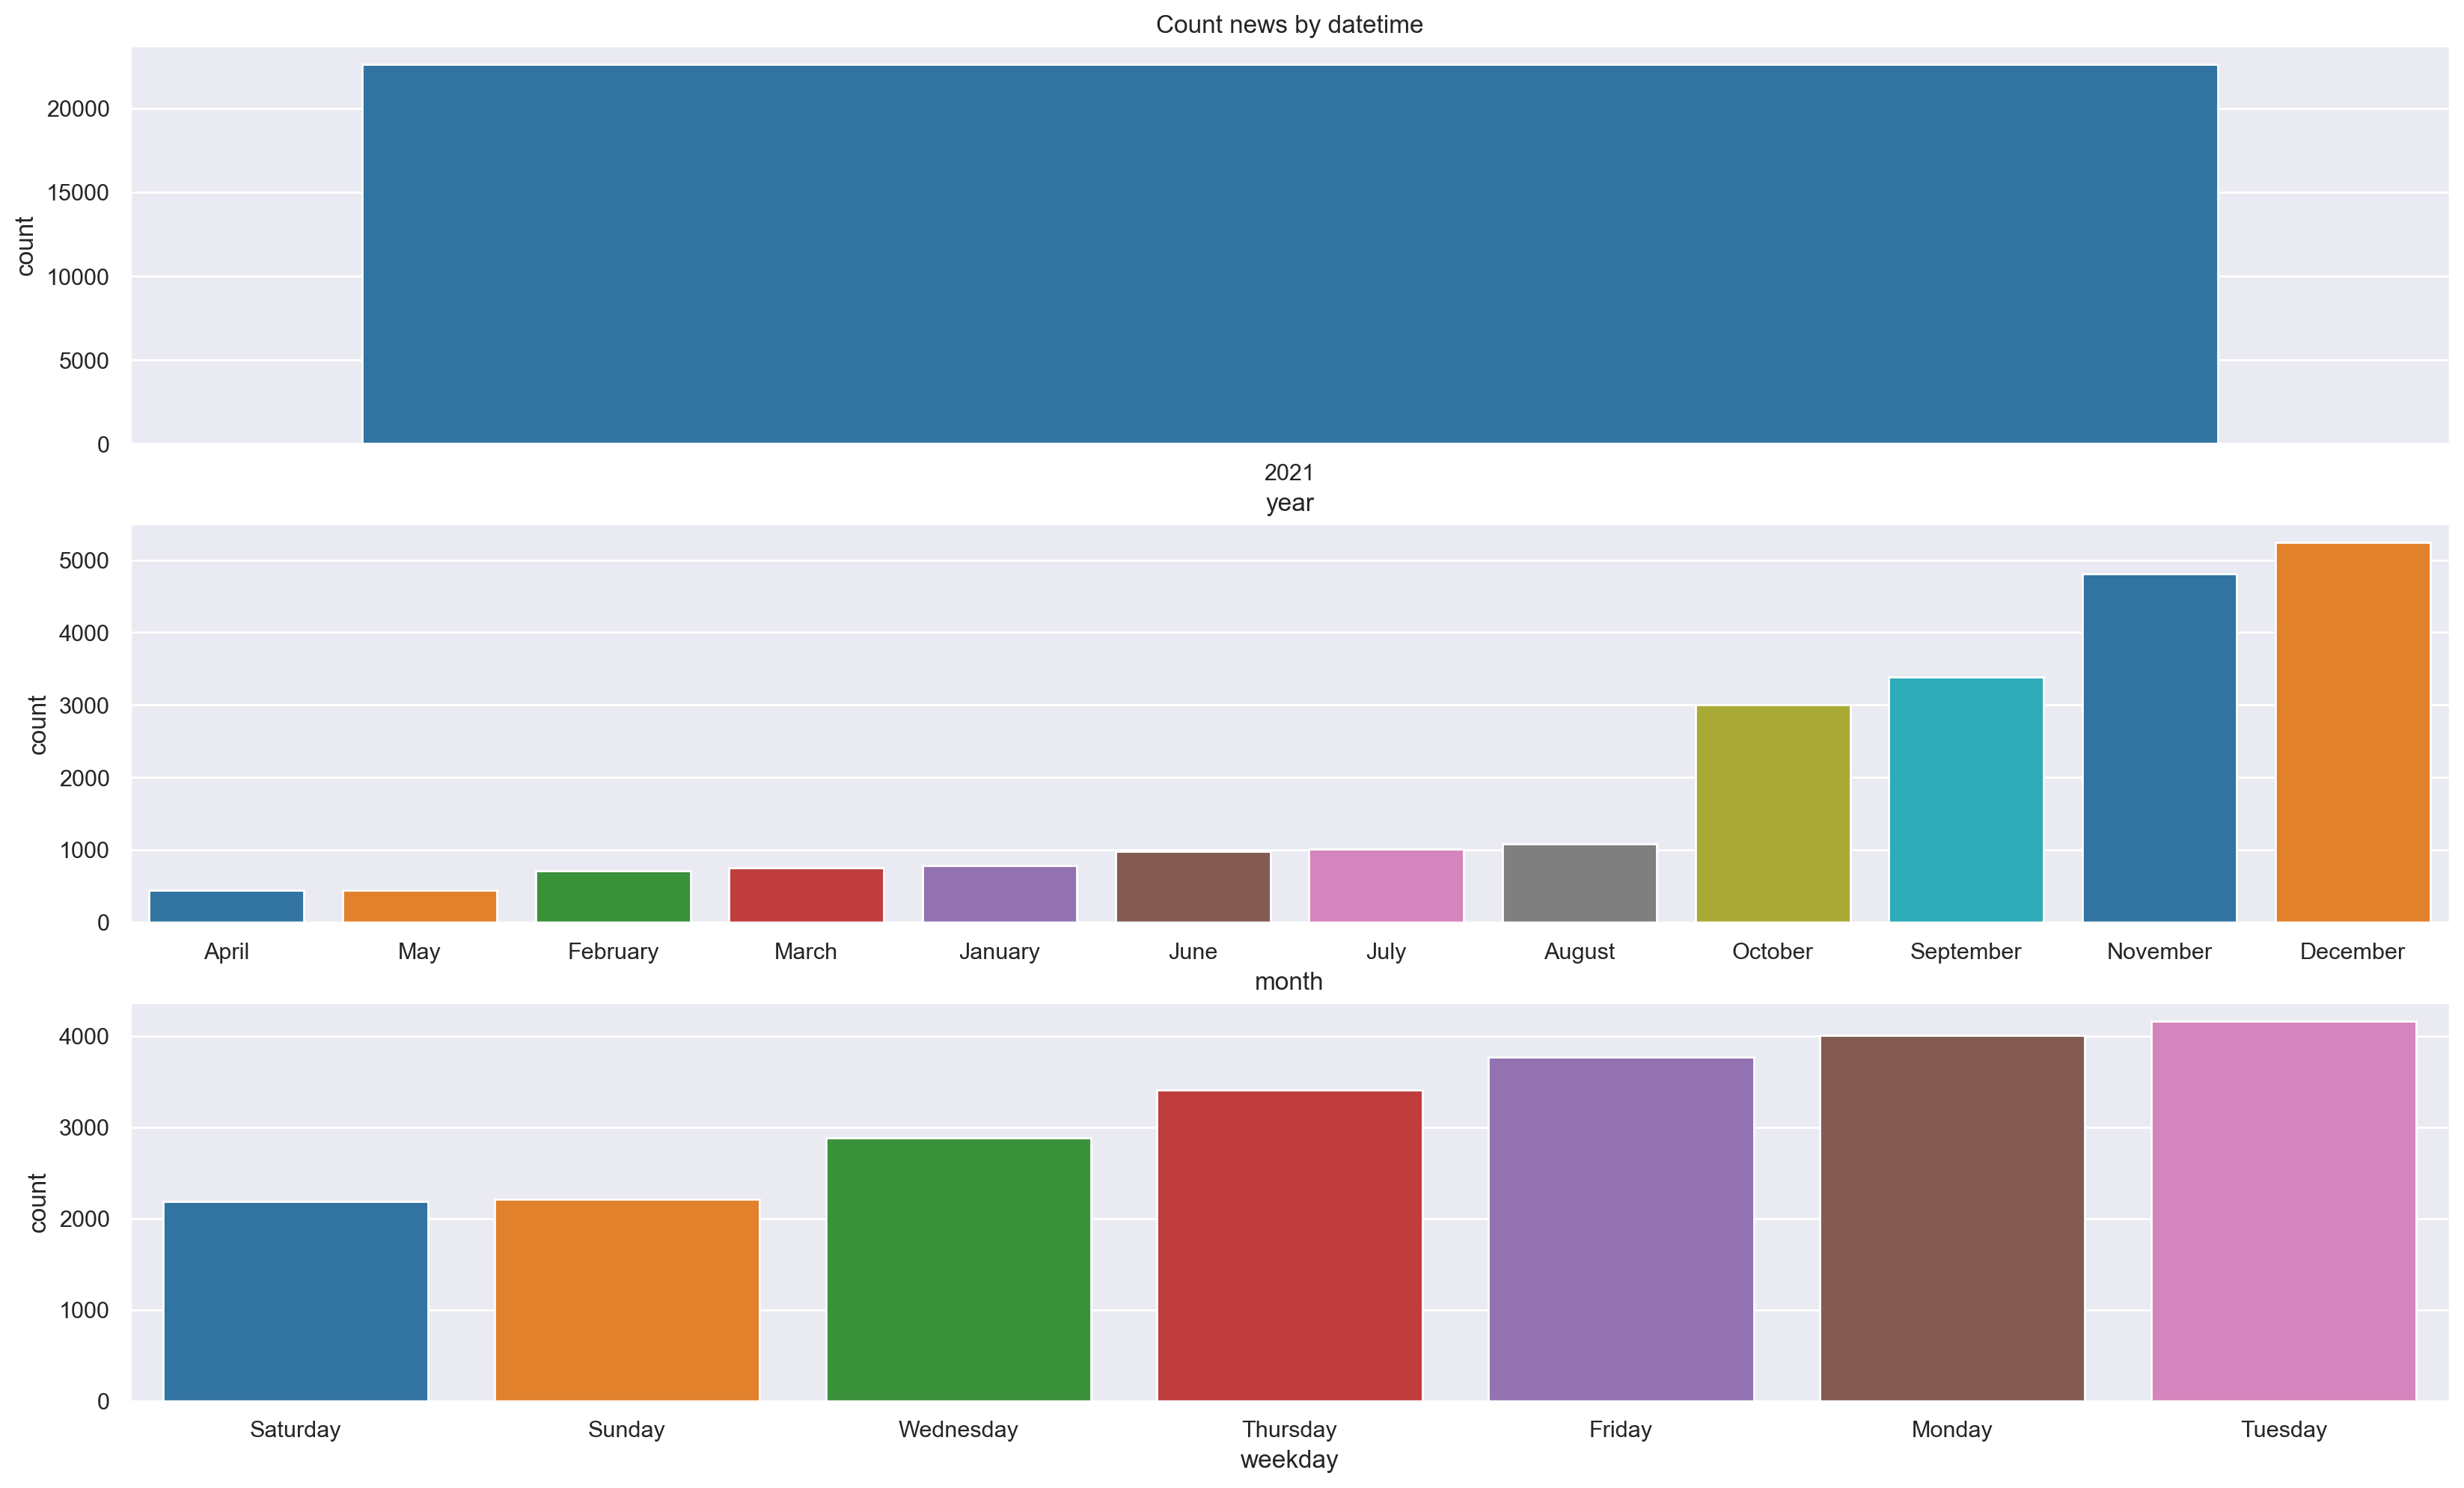

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(20, 12), dpi=200)
for ind, col in enumerate(['year', 'month', 'weekday']):
    sns.countplot(x=df[col], palette='tab10', ax=axs[ind], order=df[col].value_counts(ascending=True).index)
axs[0].set_title('Count news by datetime');

Посмотрим на распределение числа просмотров по каждой из тематик. Видим, что имеются очень тяжелые хвосты в каждой из тем, то есть в датасете присутствуют статьи, сильно выделяющиеся по своей популярности. Однако, сразу нужно отметить, что количество просмотров также зависит от возраста статьи, поэтому зависимость популярности от количества просмотров имеет не линейную, а более сложную зависимость.

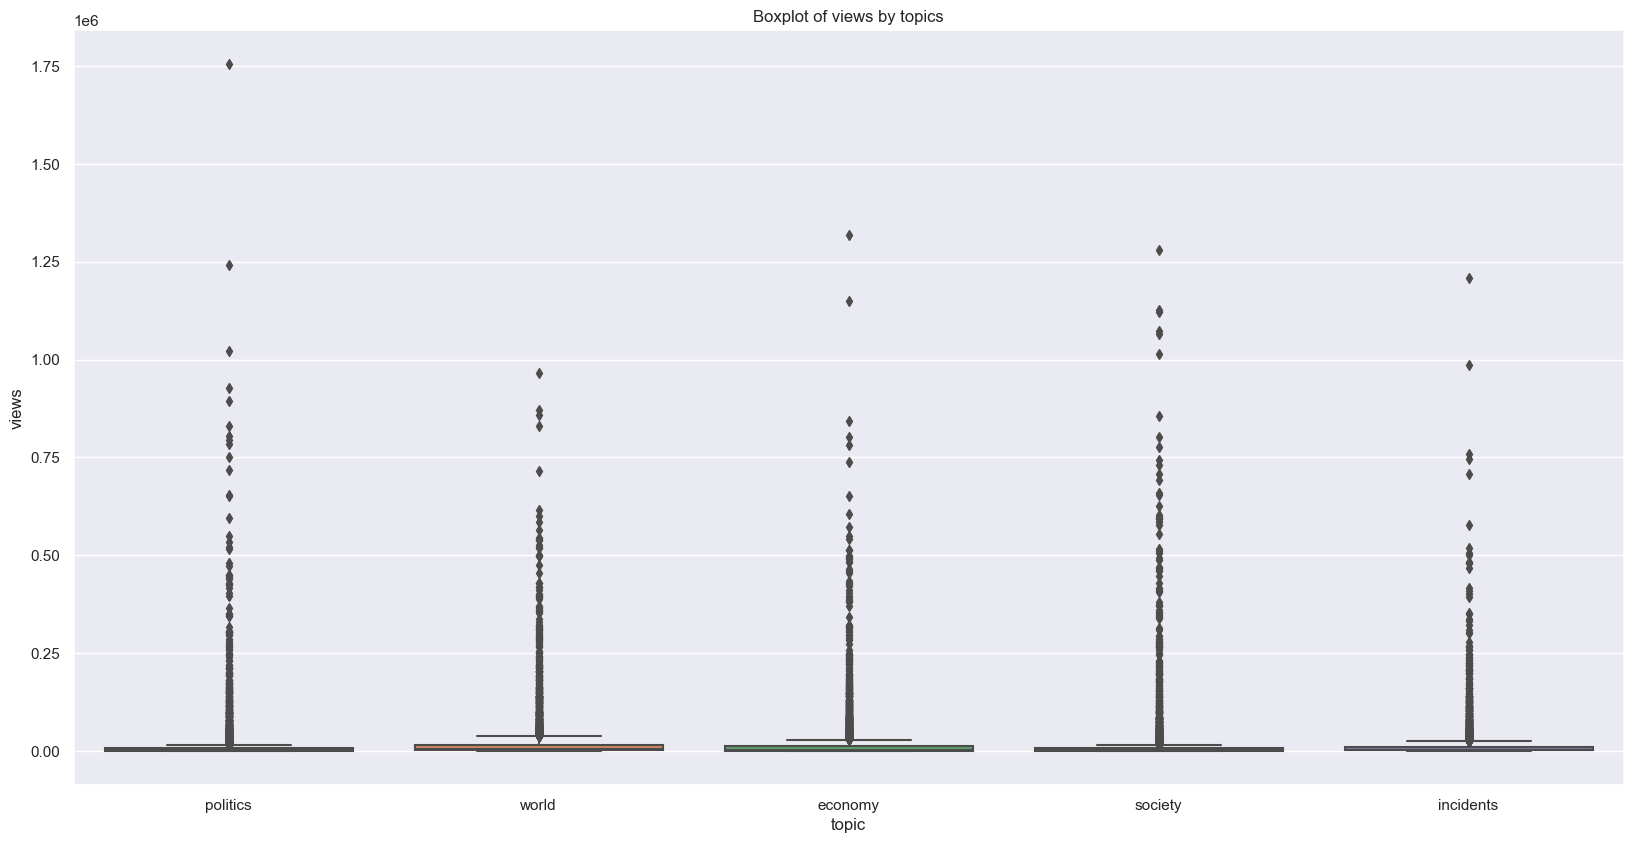

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10), dpi=100)
sns.boxplot(x="topic", y="views", data=df, ax=ax)
plt.title('Boxplot of views by topics');

Рассмотрим в целом на распределение количества просмотров по всем данным.

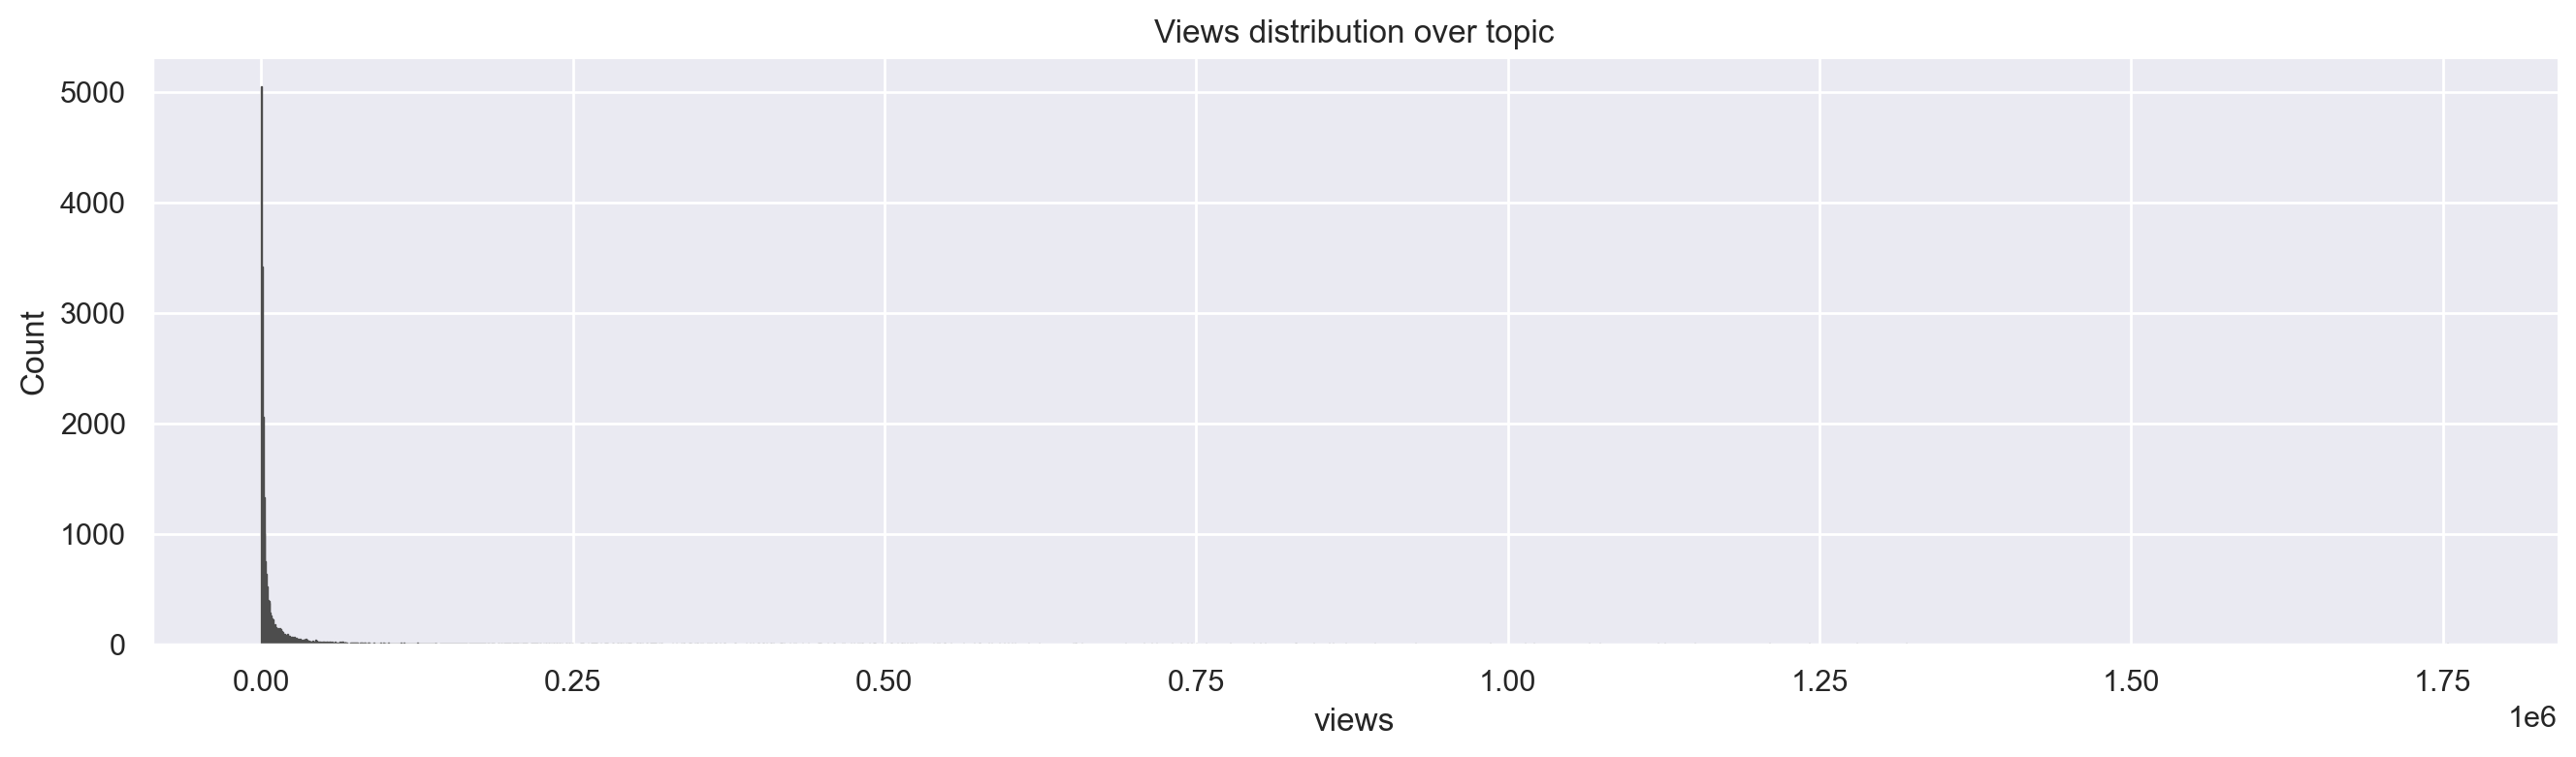

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(16, 4), dpi=200)
sns.despine(fig)

sns.histplot(
    df,
    x="views",
    edgecolor=".3",
    palette="coolwarm",
    linewidth=.5,
);
axs.set_title('Views distribution over topic');

Во-первых, как уже отмечалось, у распределения количества просмотров есть далекие выбросы. Более того, форма распределения очень похожа на логнормальное распределение. Поэтому добавим еще один признак - логарифм количества просмотров, сдвинутого на единицу, поскольку количество просмотров может принимать значение ноль.

На графике ниже по оси абсцисс отложен log1p количества просмотров, а по оси ординат - количество статей разных тематик, имеющих такое количество просмотров. Видно, что теперь распределение имеет форму, близкую к нормальному распределению, хоть оно немного скошено вправо и имеет отрицательный коэффициент асимметрии (skewness).

In [ ]:
df['log_views'] = np.log1p(df['views'])

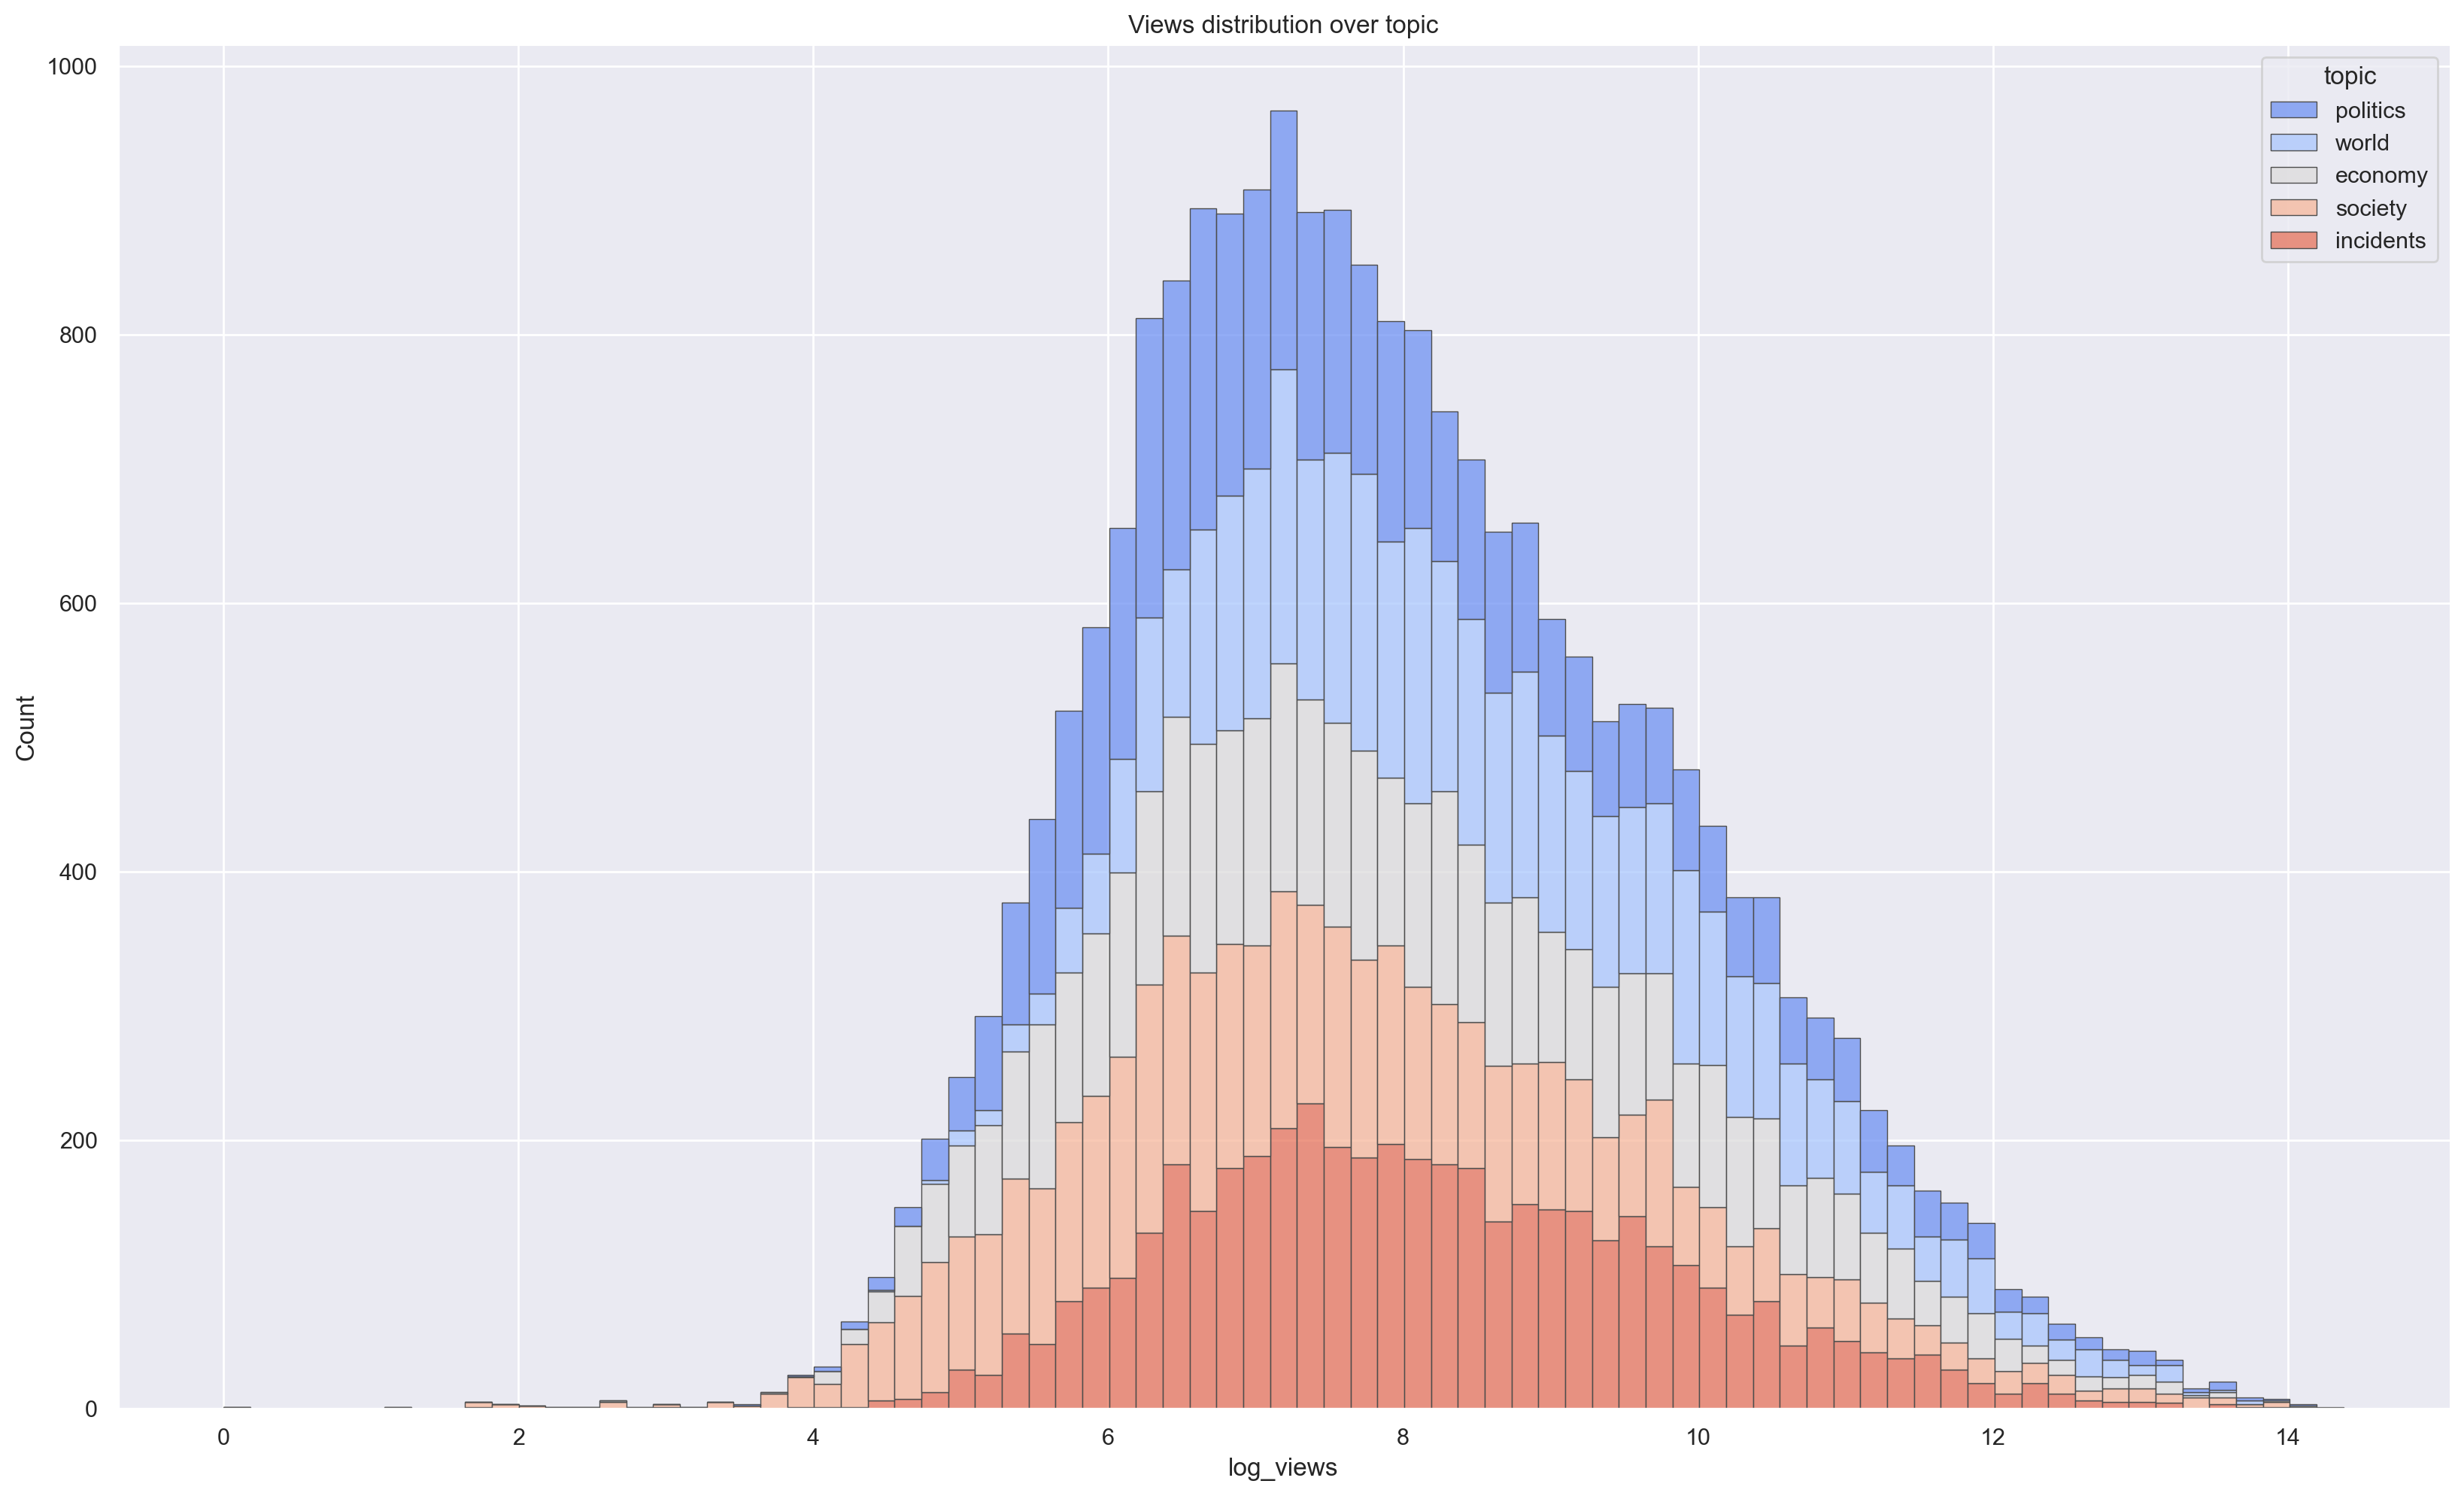

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(20, 12), dpi=200)
sns.despine(fig)

sns.histplot(
    df,
    x="log_views",
    hue="topic",
    multiple="stack",
    edgecolor=".3",
    palette="coolwarm",
    linewidth=.5,
);
axs.set_title('Views distribution over topic');

Воспользуемся критерием Манна-Уитни, чтобы проверить, насколько распределение просмотров близко к логнормальному.

In [ ]:
from scipy.stats import mannwhitneyu

# Генерируем выборку из нормального распределения с таким же мат. ожиданием и дисперсией, как у нашей переменной
x = np.random.normal(loc=df['log_views'].mean(), scale=df['log_views'].std(), size=100000)

# Проводим тест Манна-Уитни и получаем p-значимость
U1, p = mannwhitneyu(x, df['log_views'])

print('P-значимость:', p)

# Возьмем границу принятия решения 1%
if p < 0.01:
    print('Распределение количества просмотров можно считать логнормальным')
else:
    print('Распределение количества просмотров нельзя считать логнормальным')

P-значимость: 2.1560344684759215e-08
Распределение количества просмотров можно считать логнормальным


Посчитаем длину заголовков и основного текста.

In [ ]:
df['len_title'] = df['title'].str.len()
df['len_subtitle'] = df['subtitle'].str.len()
df['len_content'] = df['content'].str.len()

Посмотрим, как они выглядят в разрезе каждой категории.

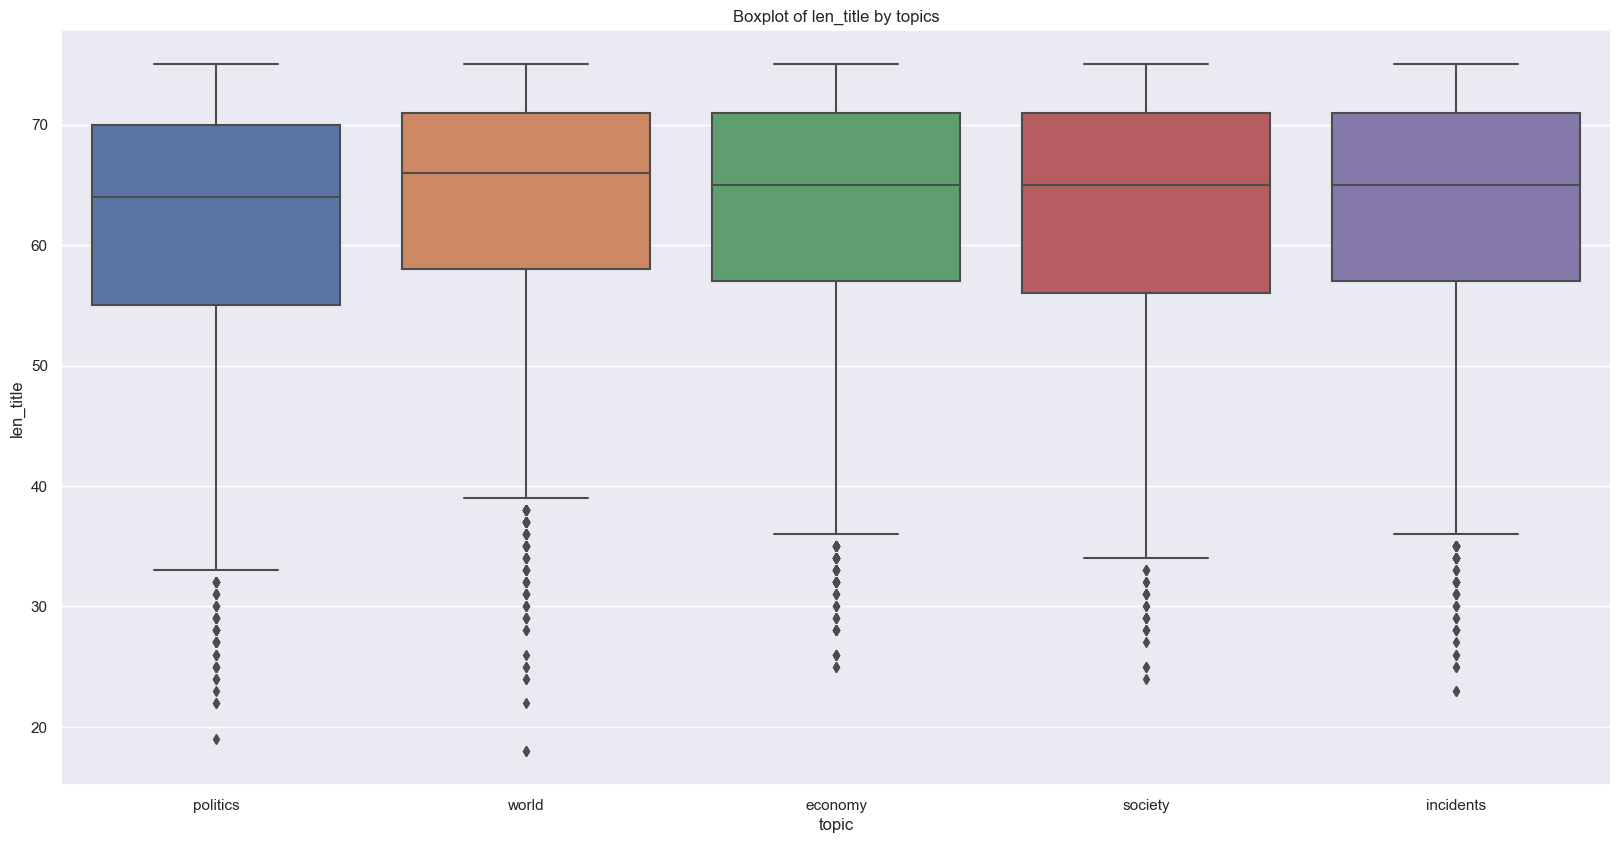

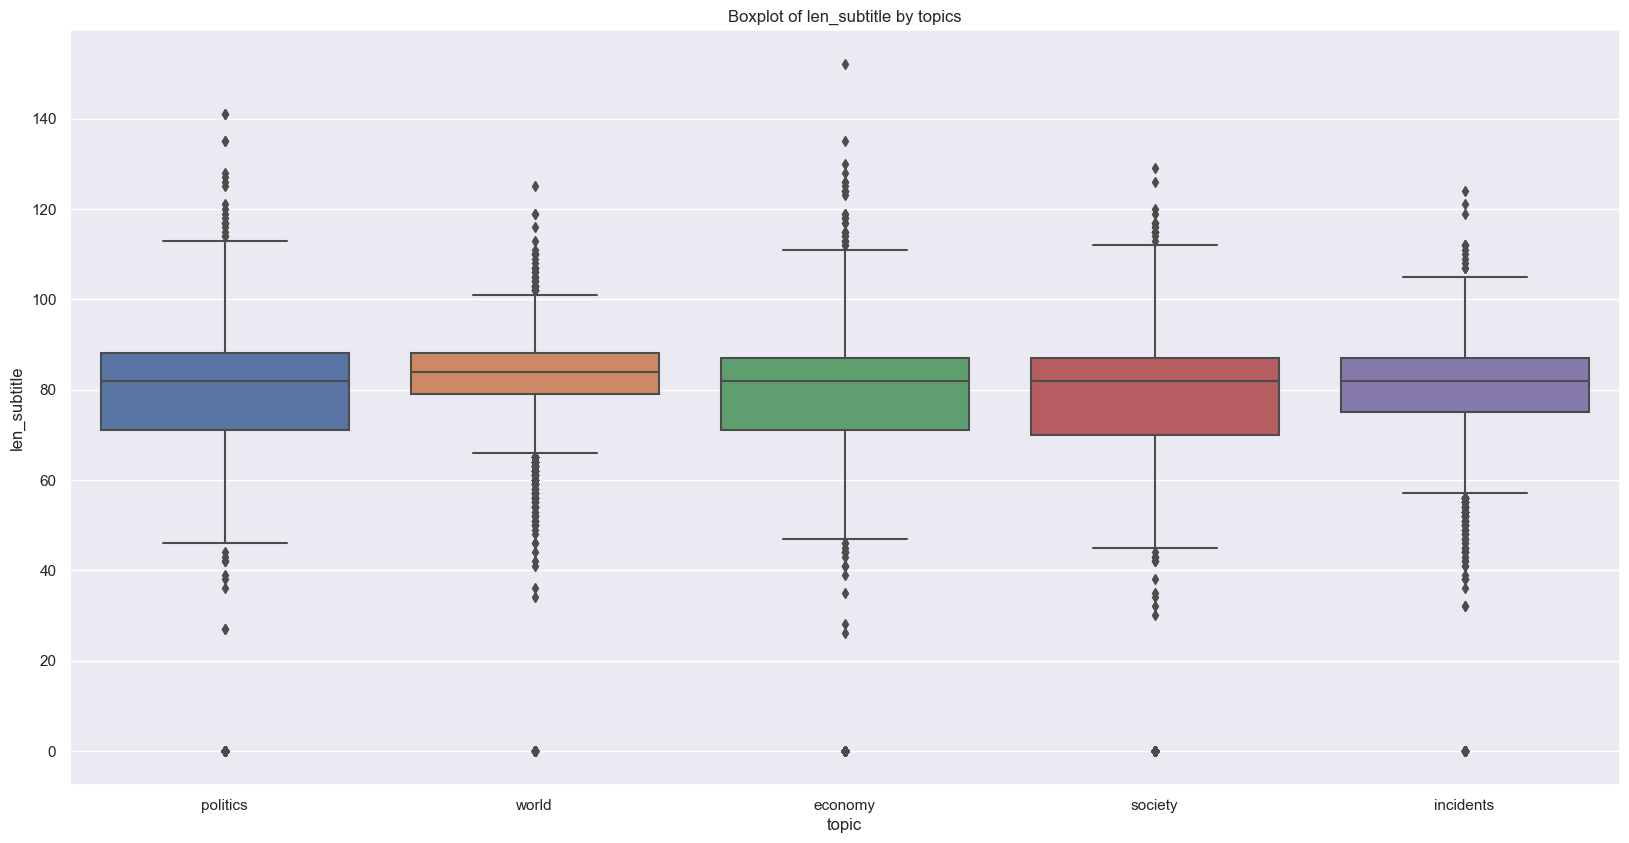

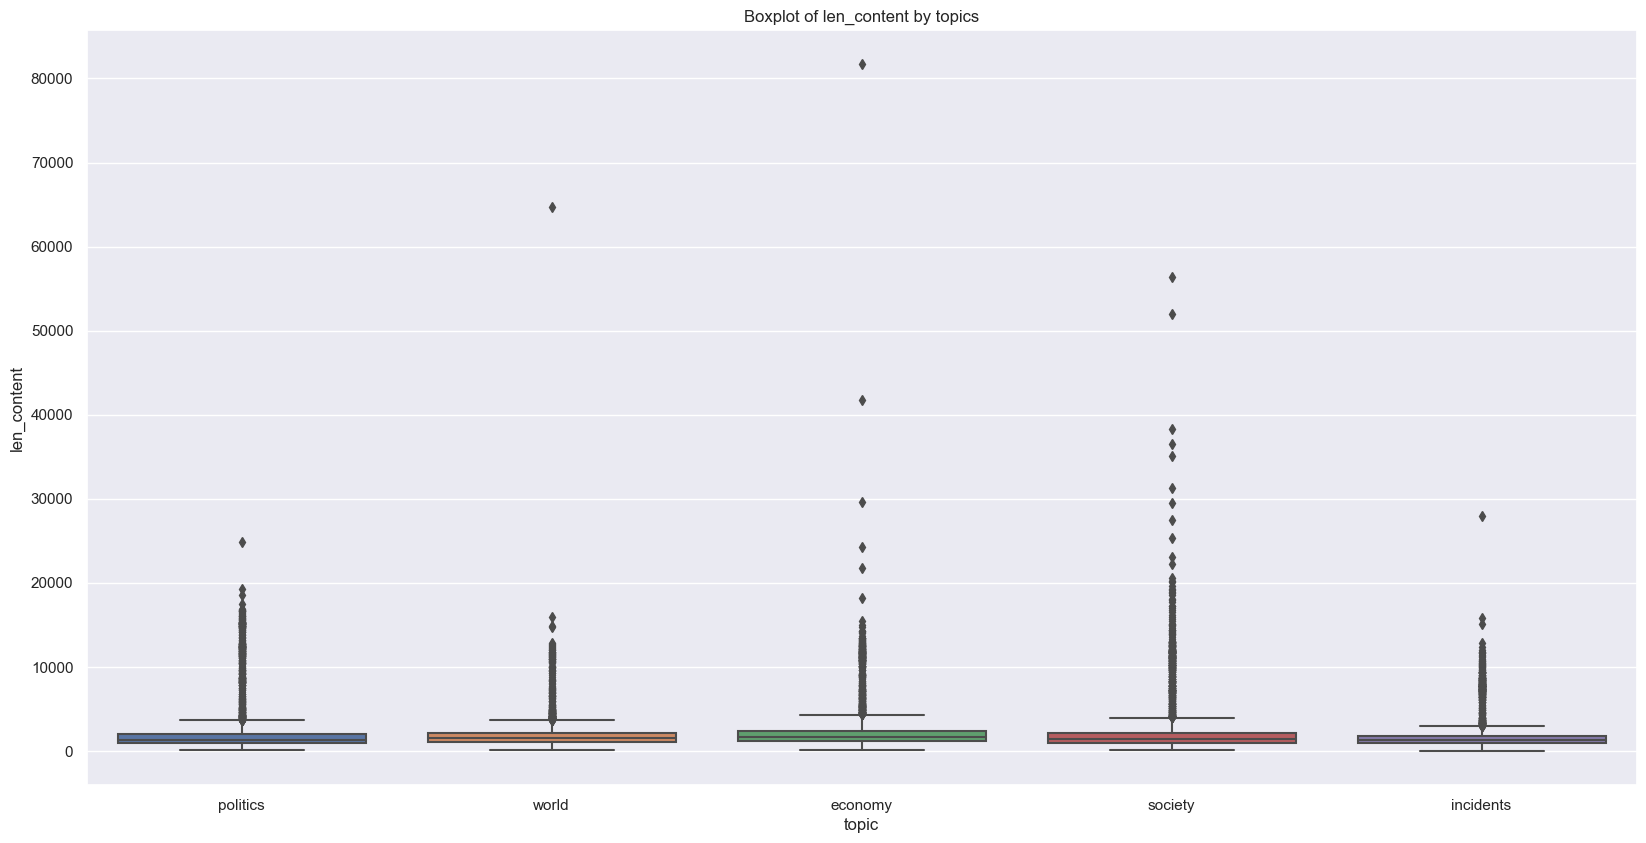

In [ ]:
for col in ['len_title', 'len_subtitle', 'len_content']:
    fig, ax = plt.subplots(1, 1, figsize=(20, 10), dpi=100)
    sns.boxplot(x="topic", y=col, data=df, ax=ax)
    plt.title(f'Boxplot of {col} by topics');

Что можно заметить:
- В среднем длина заголовка по всем категориям около 65 символов
- Второй загловок по некоторым статьям недоступен - поэтому в будущем его следует отбросить
- Длина текста имеет тяжелые хвосты, особенно по категориям: 'world', 'economy topic', 'society'

Посмотрим, какие ключевые слова чаще всего встречаются в статьях каждой тематики. Одной из гипотез является то, что статьи разных, но при этом близких тематик с одинаковыми ключевыми словами могут вносить негативный вклад в работу модели.

In [ ]:
stop_words = stopwords.words('russian')
stop_words.extend(['что', 'это', 'так',
                    'вот', 'быть', 'как',
                    'в', '—', 'к', 'за', 'из', 'из-за',
                    'на', 'ок', 'кстати',
                    'который', 'мочь', 'весь',
                    'еще', 'также', 'свой',
                    'ещё', 'самый', 'ул', 'комментарий',
                    'английский', 'язык'])

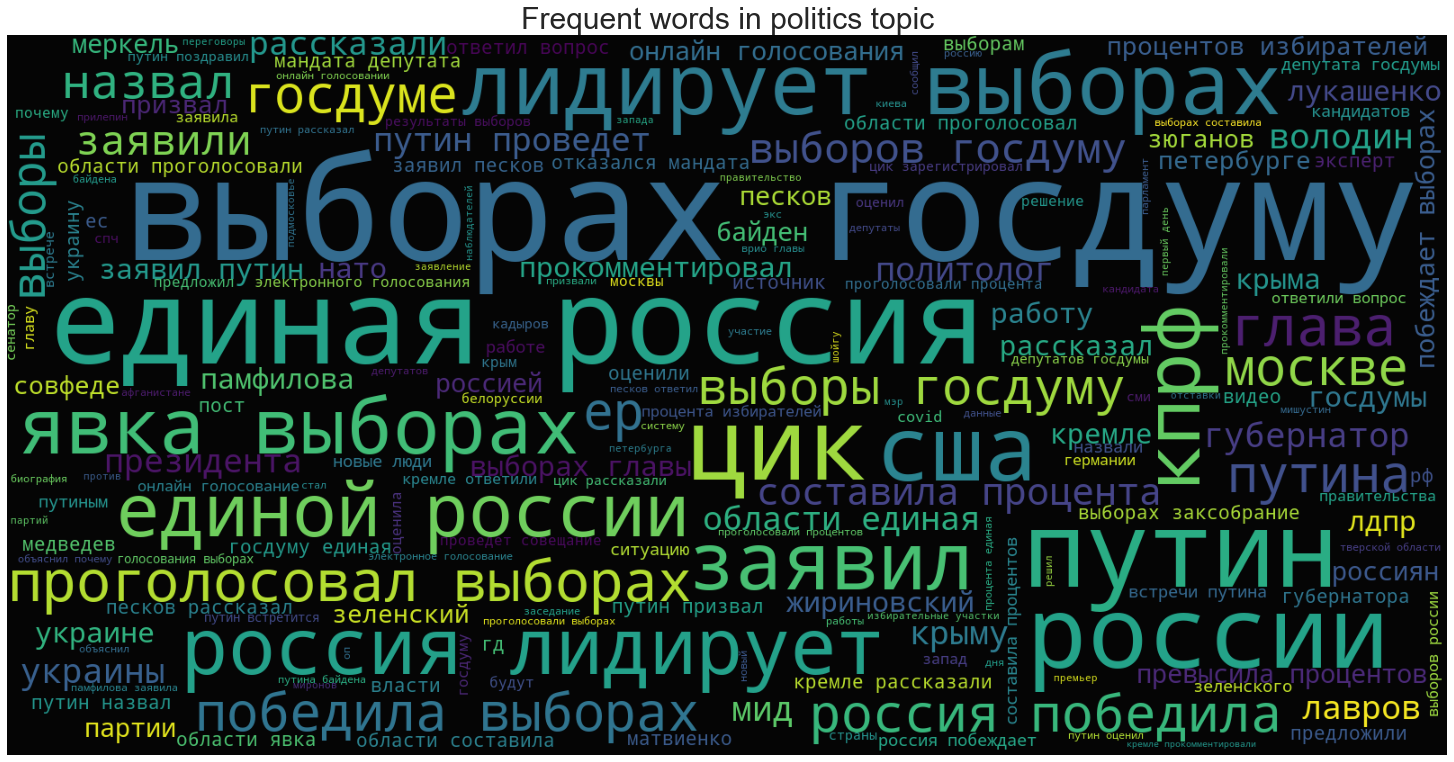

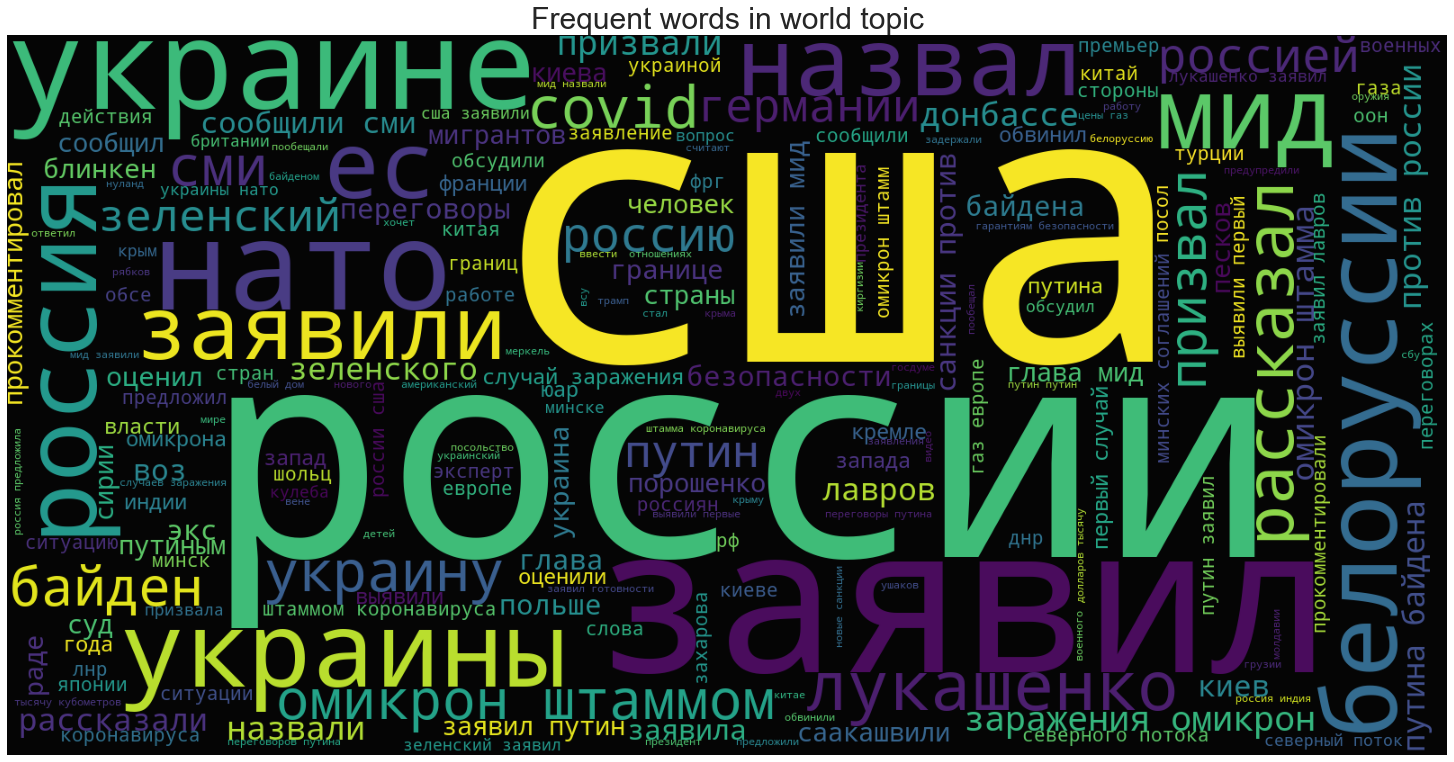

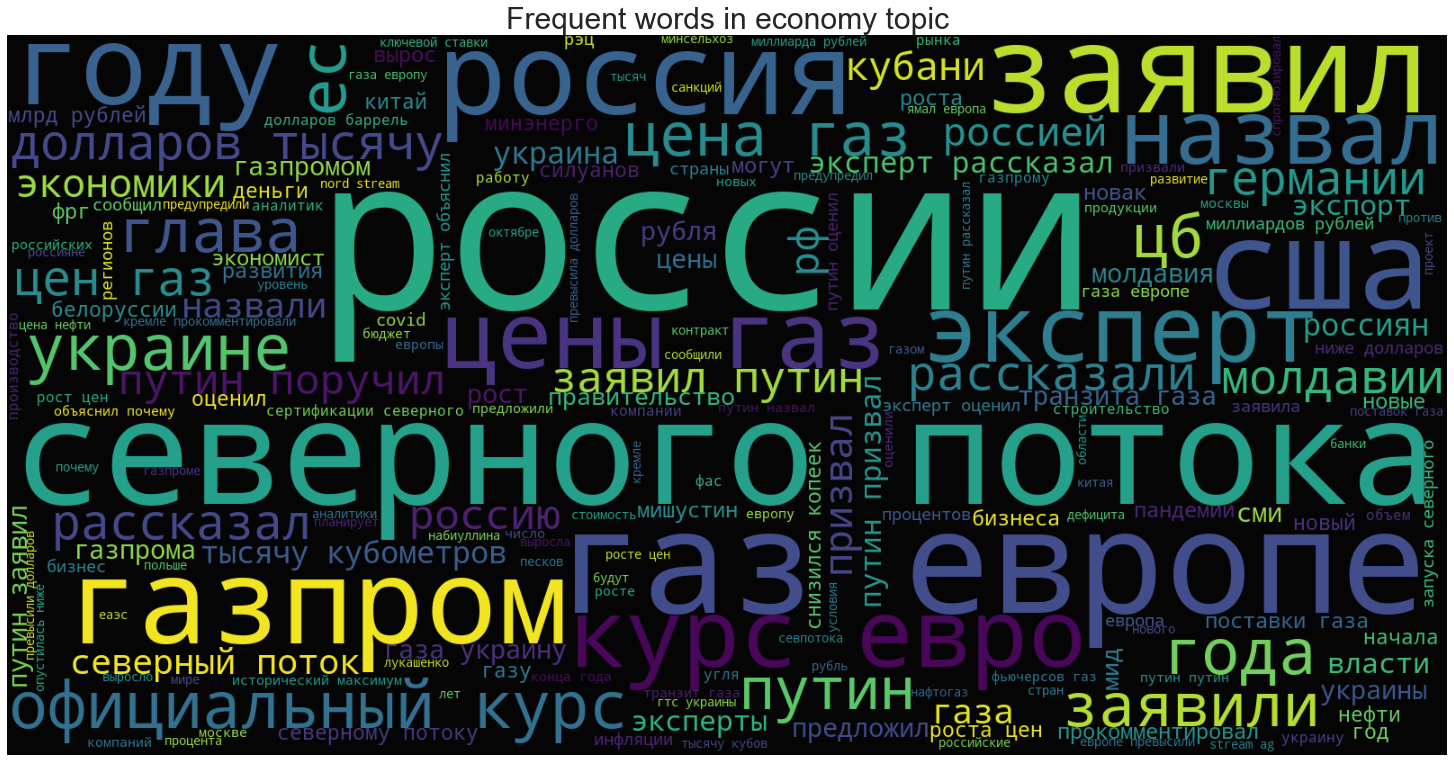

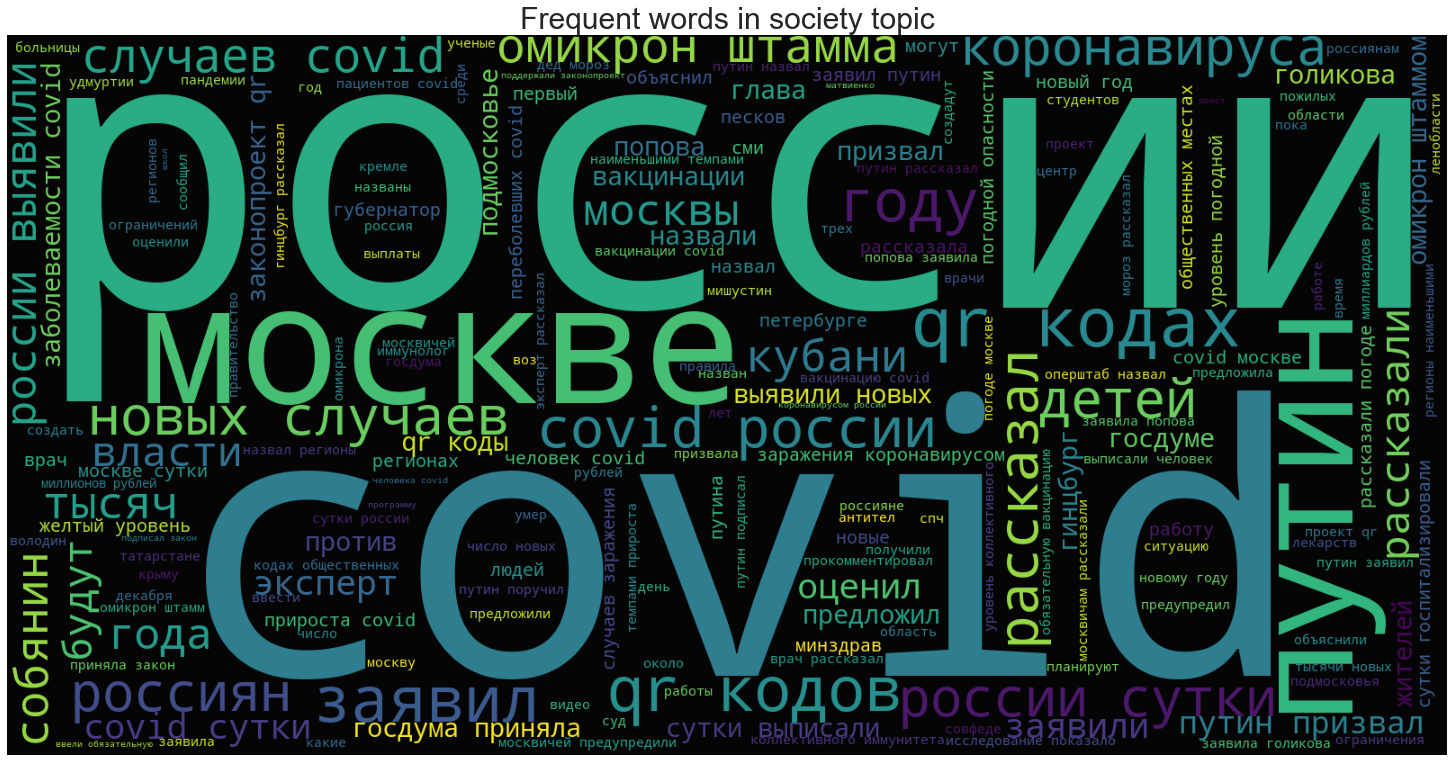

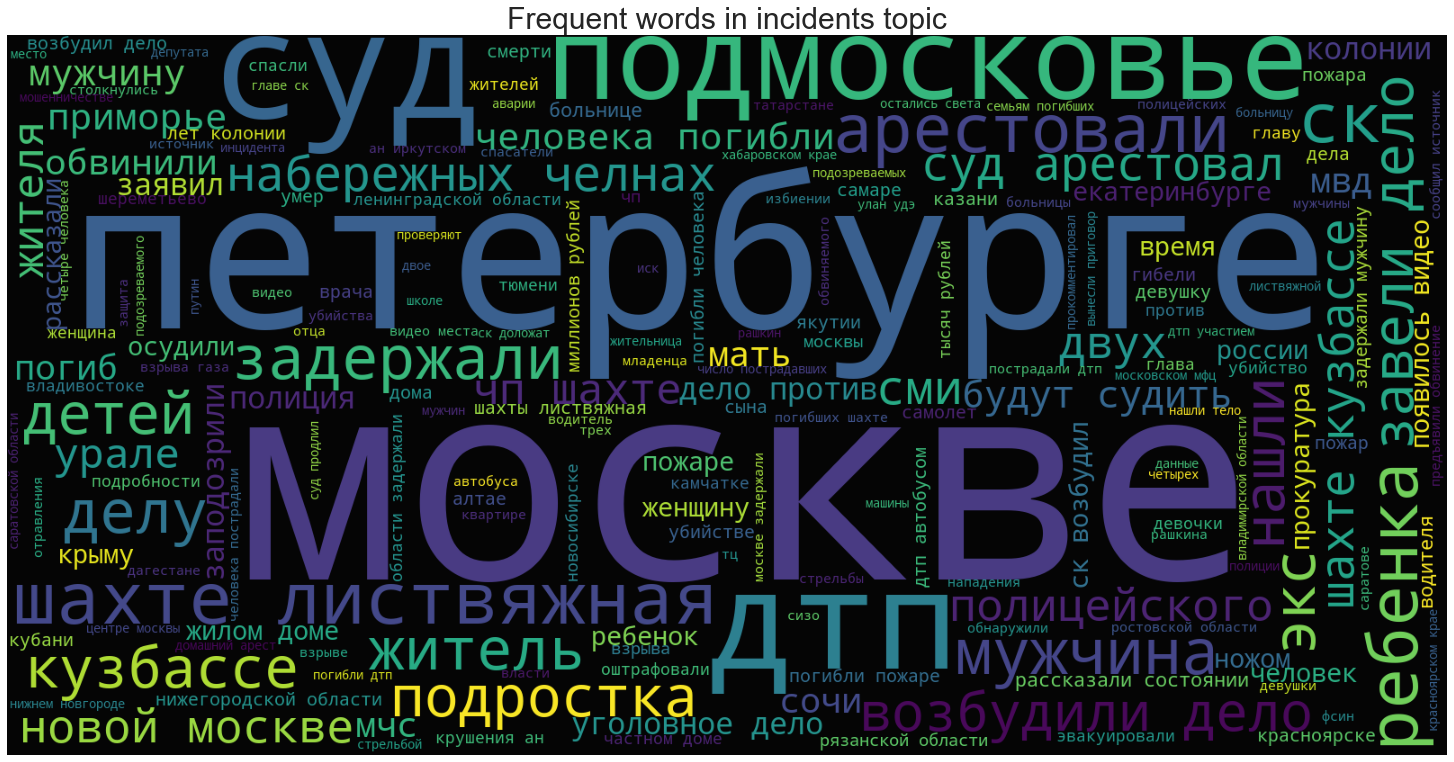

In [ ]:
for topic in df.topic.unique():
    words = df[df.topic == topic].title.str.split(' ').explode().values
    words = [word.lower() for word in words if word.lower() not in stop_words]

    wc = WordCloud(background_color="black", width=1600, height=800)
    wc.generate(" ".join(words))

    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    plt.axis("off")
    plt.tight_layout(pad=0)
    ax.set_title(f"Frequent words in {topic} topic", fontsize=30)
    ax.imshow(wc, alpha=0.98)


На данный момент мы выкачиваем статьи в обратном хронологическом порядке. Это значит, что в выборку попадают, как старые, так и совершенно новые статьи. Это сильно влияет на один из признаков - количество просмотров. Поэтому для корректной работы модели необходимо будет каким-то образом отнормировать этот признак. Для этого сначала посмотрим распределение возраста статей, а затем распределение отношения количества просмотров к возрасту статьи. Это будет не столь корректной оценкой, потому что количество просмотров со временем растет нелинейно. Скорее всего, эта зависимость имеет экспоненциальный характер с некоторой линией насыщения - асимптотой. Но для нулевого приближения попробуем сначала рассмотреть самый простой вариант.

In [ ]:
df['lifetime'] = df['datetime'].apply(lambda x: (datetime.datetime.now() - x).total_seconds())
df['lifetime'] = df['lifetime'].apply(lambda x: divmod(x, 60)[0]) # lifetime in minutes

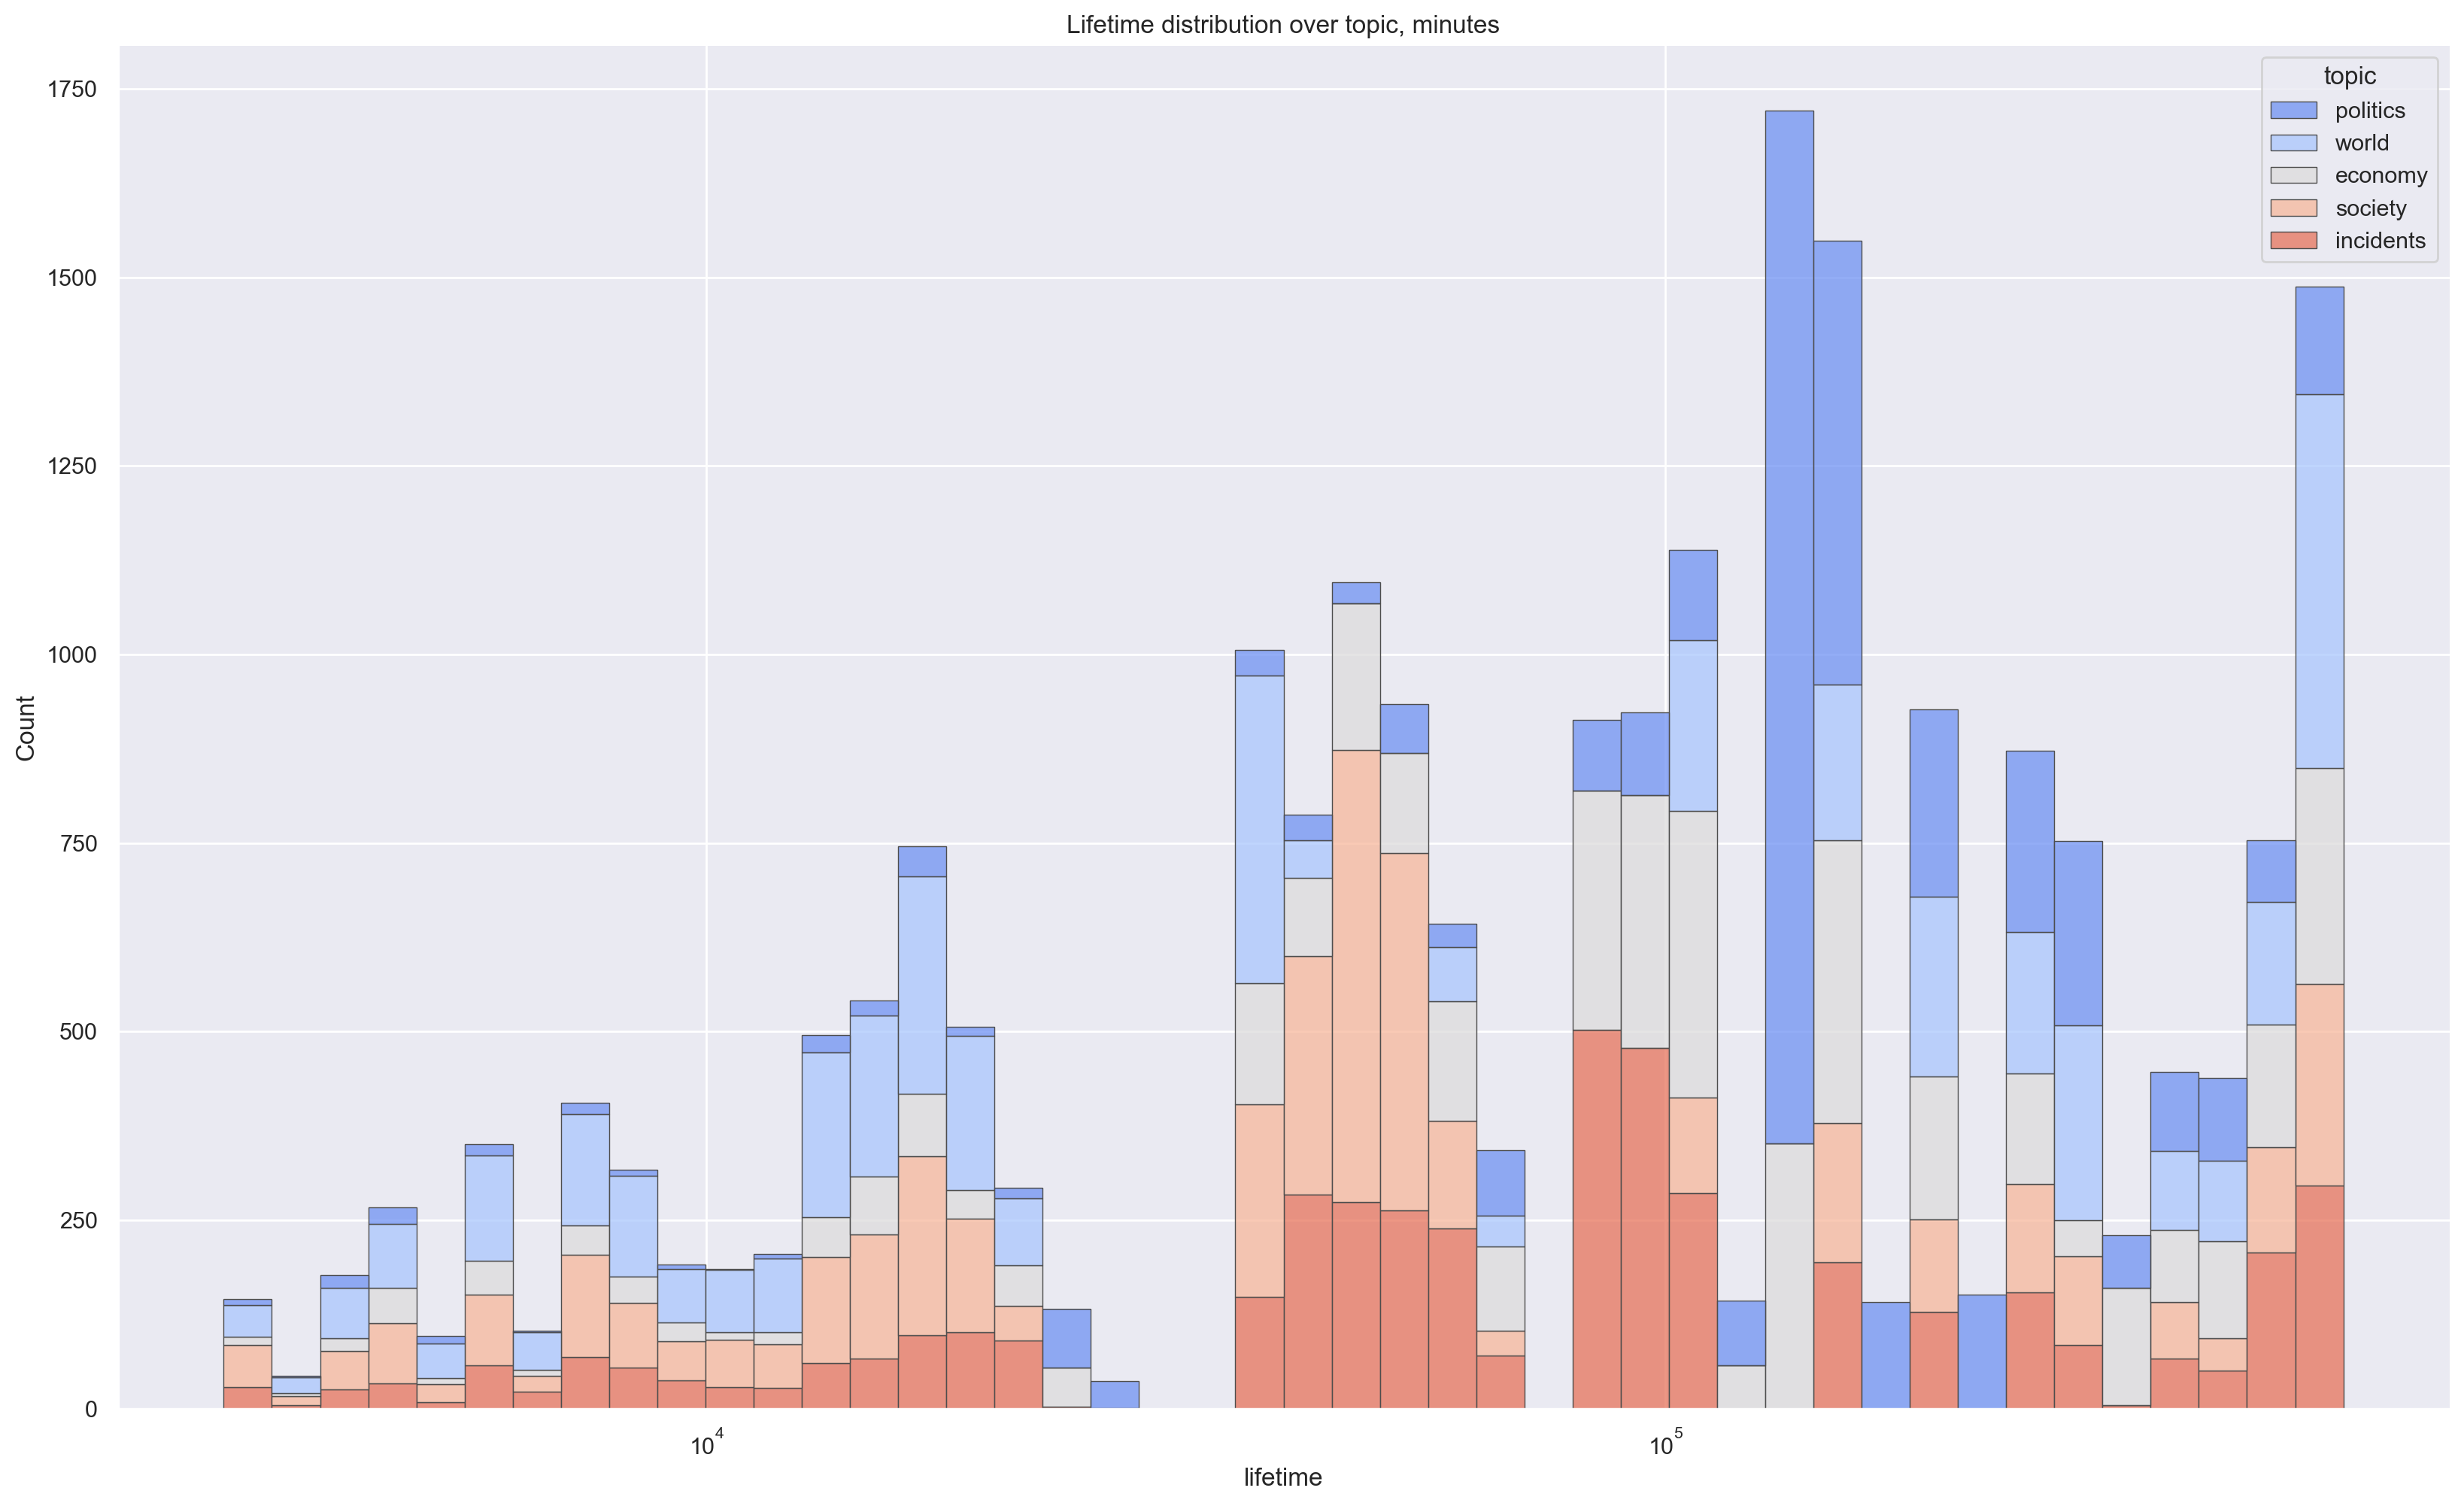

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(20, 12), dpi=200)
sns.despine(fig)

sns.histplot(
    df,
    x="lifetime",
    hue="topic",
    multiple="stack",
    edgecolor=".3",
    palette="coolwarm",
    linewidth=.5,
    log_scale=True,
);
axs.set_title('Lifetime distribution over topic, minutes');

Как и ожидалось, в датасете присутствуют как старые статьи, так и новые. И само распределение имеет довольно неоднозначную форму.

In [ ]:
df['views_by_minutes'] = (df['views'] + 1) / df['lifetime']

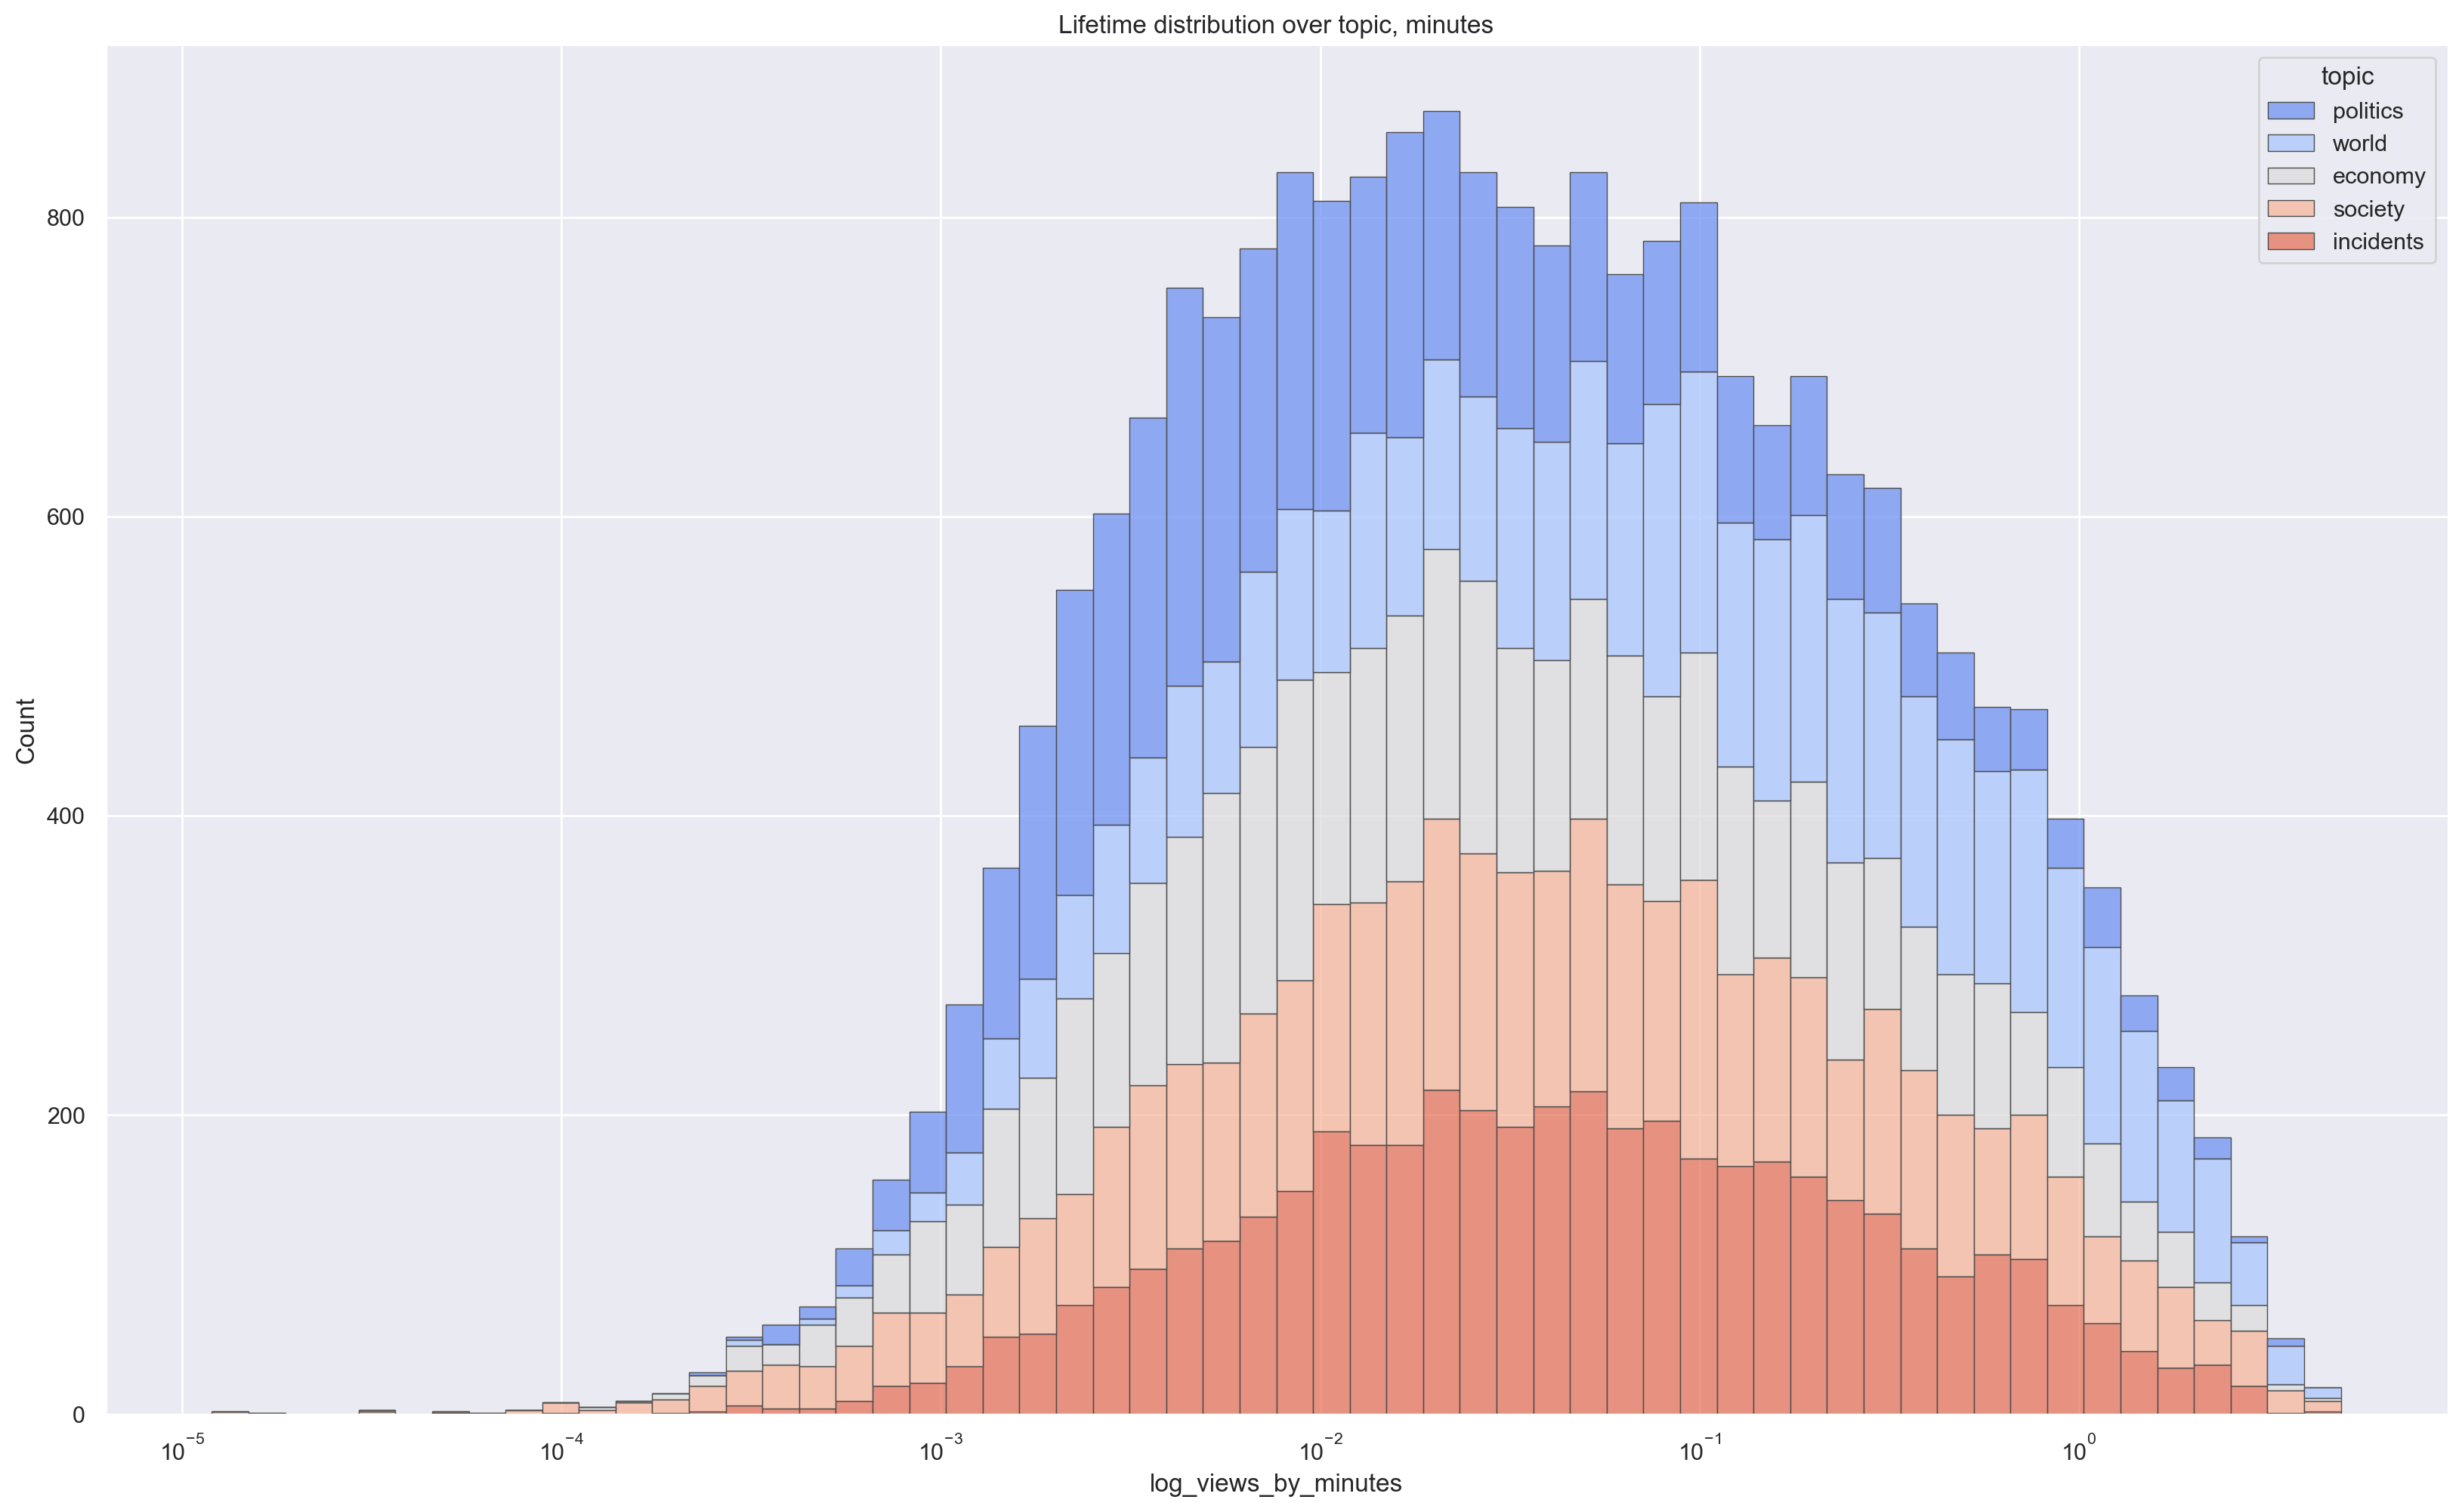

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(20, 12), dpi=200)
sns.despine(fig)

sns.histplot(
    df,
    x="log_views_by_minutes",
    hue="topic",
    multiple="stack",
    edgecolor=".3",
    palette="coolwarm",
    linewidth=.5,
    log_scale=True,
);
axs.set_title('Lifetime distribution over topic, minutes');

А вот новый признак - количество просмотров в минуту, или средняя скорость роста количества просмотров, - имеет уже распределение, близкое к логнормальному, и с таким признаком уже можно как-то работать.

### Выводы

Итак, на данном этапе мы провели первичный анализ датасета. Статьи распределены по тематикам достаточно равномерно. Все новости относятся к 2021 году, а больше всего новостей в ноябре и декабре, но это всё потому, что мы выгружали данные в обратном хронологическом порядке и, соответственно, большая часть статей выпала на ноябрь и декабрь. По дням недели на текущих данных можно судить уже больше. Меньше всего новостей выходит в выходные и больше всего в первый и второй рабочие дни недели - понедельник и вторник.

Не у всех статей есть подзаголовок, поэтому в дальнейшем мы его из признаков исключим. В среднем длина заголовка по всем категориям около 65 символов. Длина текста имеет тяжелые хвосты, особенно по категориям 'world', 'economy topic' и 'society'.

Мы также проанализировали основные ключевые слова, которые наводят на гипотезу о том, что статьи разных тематик могут быть сильно похожи по доминирующим ключевым словам и тем самым негативно влиять на модель. Это нужно будет иметь в виду при построоении модели.

Одним из важных, на первый взгляд, признаков является количество просмотров, поскольку в каждый период времени наиболее популярными будут статьи на актуальные для данного промежутка времени темы. Однако, количество просмотров сильно зависит от возраста статьи, поэтому мы добавили новый признак - средняя скорость роста количества просмотров, - которая, как оказалось, имеет нормальное распределение, что мы проверили по критерию Манна-Уитни.

Поскольку мы работаем с текстами, на этом этапе пока не столь очевидно, какие данные и по какой причине стоит считать выбросами, а какие - особенностями конкретной тематики. Поэтому это мы оставим на следующие этапы работы над проектом.